#### **Output**: 
#### sequences with 3 month objective in `workspace/sequences_with_checkup_3_dict.pickle`
#### sequences with 3 + 12 month objective in `workspace/sequences_with_checkup_3-12_dict.pickle`

- measurements in the sequence contain an OCT measurement, the checkups contain a VA measurement
- for these sequences, events were added to the next measurement. Meaning that at any given measurement, we know which interventions happened before this intervention! 
- the checkup measurements contain information on the interventions that happened between the last measurement and the checkup (e.g. this will be necessary information to model)

# Dataset with 3 month objective / 12 month objective

In [30]:
import sys
sys.path.append('../')
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook as tqdm
from datetime import datetime
import time
import matplotlib.colors as mcolors
import sequences
import importlib
plt.rcParams['figure.facecolor'] = 'white'
importlib.reload(sequences)

<module 'sequences' from '../sequences.py'>

## Load data

In [2]:
workspace_dir = '../../workspace' #'/storage/groups/ml01/workspace/hannah.spitzer/LODE'
longitudinal_data = pd.read_csv(os.path.join(workspace_dir, 'longitudinal_data.csv'), index_col=0)
# filter measurements for which could not calculate features
octs_to_remove = pd.read_csv('../../data/non_segmented_octs.csv', index_col=0)
longitudinal_data = longitudinal_data[~longitudinal_data.oct_path.isin(octs_to_remove['0'])]

events = pd.read_csv(os.path.join(workspace_dir, 'longitudinal_events.csv'), index_col=0)
events = events.sort_values('study_date')
events.loc[:,'visus?'] = False
events.loc[:,'oct?'] = False

In [3]:
# get grouped patients (sorted by date)
# keep NAN octs and logMARs (can still build sequence from them)
# remove patients without cleaned diagnosis label (currently only AMD and DR have diagnosis label)
filtered = longitudinal_data.dropna(subset=['diagnosis'])  
all_patients = filtered.sort_values('study_date')
# drop all groups that do not have at least one OCT and one logMAR
grouped = all_patients.groupby(['patient_id', 'laterality'])
all_patients = grouped.filter(lambda x: x.oct_path.count()>0 and x.logMAR.count() > 0)

grouped_patients = all_patients.groupby(['patient_id', 'laterality'])
grouped_events = events.groupby(['patient_id', 'laterality'])

## Calculate sequences

In [4]:
# create sequences with events added to next mmt
seqs = []
i = 0
for name, group in tqdm(grouped_patients):
    # get events for this group
    group_events = None
    try:
        group_events = grouped_events.get_group(name)
    except KeyError as e:
        pass

    seq = sequences.MeasurementSequence.from_pandas(group)
    seq.add_events_from_pandas(group_events, how='next')  # ADD EVENTS TO NEXT MEASUREMENT!!!
    seqs.append(seq)

/Users/hannah.spitzer/opt/miniconda3/envs/lode/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [5]:
# parameters for sequence generation
req_sequence_oct = True
req_sequence_va = True # could just require VA for initial mmt if need more measurements
req_checkup_oct = False
req_checkup_va = True

In [6]:
seq = seqs[5]
# create sequences with 3 month / 12 month checkup
sequences_checkup_3 = []
sequences_checkup_3_12 = []
for seq in tqdm(seqs):
    # get seq_ids - all mmts fullfilling criterion
    seq_ids = []
    for seq_id in range(len(seq)):
        if seq.measurements[seq_id].is_valid(req_oct=req_sequence_oct, req_va=req_sequence_va):
            seq_ids.append(seq_id)
    # iterate over all possible end_ids - mmt with has_checkup()
    for i,end_id in enumerate(seq_ids):
        checkup_3_id = seq.has_checkup(end_id, req_oct=req_checkup_oct, req_va=req_checkup_va)
        checkup_12_id = seq.has_checkup(end_id, checkup_time=360, max_deviation=30, 
                                    req_oct=req_checkup_oct, req_va=req_checkup_va)
        if checkup_3_id:
            #print(seq_ids[0:i+1]+[checkup_3_id])
            # is valid end_id for 3
            # get new subsetted sequence
            seq_sub = seq.subset(seq_ids[0:i+1]+[checkup_3_id])
            sequences_checkup_3.append(seq_sub)
            if checkup_12_id:
                # is valid end_id for 3-12
                # get new subsetted sequence
                seq_sub = seq.subset(seq_ids[0:i+1]+[checkup_3_id,checkup_12_id])
                sequences_checkup_3_12.append(seq_sub)
            


/Users/hannah.spitzer/opt/miniconda3/envs/lode/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [7]:
# save sequences to file to avoid recomputing
sequences.save_sequences_to_pickle(os.path.join(workspace_dir, 'sequences_with_checkup_3_dict.pickle'), sequences_checkup_3)
sequences.save_sequences_to_pickle(os.path.join(workspace_dir, 'sequences_with_checkup_3-12_dict.pickle'), sequences_checkup_3_12)

## Generate statistics plots

In [3]:
sequences_checkup_3 = sequences.load_sequences_from_pickle(os.path.join(workspace_dir, 'sequences_with_checkup_3_dict.pickle'))
sequences_checkup_3_12 = sequences.load_sequences_from_pickle(os.path.join(workspace_dir, 'sequences_with_checkup_3-12_dict.pickle'))


In [4]:
measurement_error = 0.15

In [5]:
def calculate_statistics(seqs, num_checkups=1):
    # statistics for sequences before checkup
    stats = {
        'len': np.array([len(seq)-num_checkups for seq in seqs]),
        'dt': np.array([sum([mmt.delta_t for mmt in seq.measurements[:-num_checkups-1]]) for seq in seqs]),
        'num_inj': np.array([sum([sum(mmt.injections) for mmt in seq.measurements[:-num_checkups]]) for seq in seqs]),
        'va_mean': np.array([np.mean([mmt.cur_va for mmt in seq.measurements[:-num_checkups]]) for seq in seqs]),
        'va_std': np.array([np.std([mmt.cur_va for mmt in seq.measurements[:-num_checkups]]) for seq in seqs]),
        'ls': np.array([np.any([mmt.lens_surgery for mmt in seq.measurements[:-num_checkups]]) for seq in seqs])
    }
    return stats

def calculate_checkup_statistics(seqs, num_checkups=1, checkup_names=['checkup3']):
    # statistics for time between last measurement + checkup
    mmt_id = -num_checkups-1
    stats = {}
    for i,name in zip(range(num_checkups), checkup_names):
        checkup_id = -(num_checkups-i)
        print(mmt_id, checkup_id, name)
        res = {
            'dt': np.array([(seq.measurements[checkup_id].study_date - seq.measurements[mmt_id].study_date).days for seq in seqs]),
            'num_inj': np.array([sum(seq.measurements[checkup_id].injections) for seq in seqs]),
            'diff_va': np.array([seq.measurements[checkup_id].cur_va - seq.measurements[mmt_id].cur_va for seq in seqs]),
            'ls': np.array([seq.measurements[checkup_id].lens_surgery for seq in seqs])
        }
        stats[name] = res
    return stats

stats = calculate_statistics(sequences_checkup_3_12, num_checkups=2)
checkup_stats = calculate_checkup_statistics(sequences_checkup_3_12, num_checkups=2, checkup_names=['checkup3', 'checkup12'])


-3 -2 checkup3
-3 -1 checkup12


In [6]:
# calculate number of patients
patient_ids = np.array([seq.patient_id for seq in sequences_checkup_3_12])

print('sequences with 3 month and 12 month checkup')
print('all data: {} sequences, {} patients'.format(len(patient_ids), len(set(patient_ids))))
diff_va = checkup_stats['checkup12']['diff_va']
mask_nochange = (diff_va >= -measurement_error) & (diff_va <= measurement_error)
mask_impr = (diff_va < -measurement_error)
mask_worse = (diff_va > measurement_error)
print('no change after 12 months: {} sequences, {} patients'.format(len(patient_ids[mask_nochange]), len(set(patient_ids[mask_nochange]))))
print('improvement after 12 months: {} sequences, {} patients'.format(len(patient_ids[mask_impr]), len(set(patient_ids[mask_impr]))))
print('worse after 12 months: {} sequences, {} patients'.format(len(patient_ids[mask_worse]), len(set(patient_ids[mask_worse]))))

inj = stats['num_inj'] + checkup_stats['checkup3']['num_inj'] + checkup_stats['checkup12']['num_inj']
mask_noinj = inj == 0
print('no injections: {} sequences, {} patients'.format(len(patient_ids[mask_noinj]), len(set(patient_ids[mask_noinj]))))

mask_dr = np.array([seq.diagnosis=='DR' for seq in sequences_checkup_3_12])
print('with DR: {} sequences, {} patients'.format(len(patient_ids[mask_dr]), len(set(patient_ids[mask_dr]))))


sequences with 3 month and 12 month checkup
all data: 6284 sequences, 505 patients
no change after 12 months: 4094 sequences, 443 patients
improvement after 12 months: 903 sequences, 290 patients
worse after 12 months: 1287 sequences, 323 patients
no injections: 2855 sequences, 324 patients
with DR: 971 sequences, 66 patients


In [33]:
# calculate number of patients statified by sequence length
patient_ids = np.array([seq.patient_id for seq in sequences_checkup_3_12])
seq_len = np.array([len(seq) for seq in sequences_checkup_3_12])

data = {
    'seq_len': [],
    'num_pat': [],
    'num_seq': [],
    'num_pat_impr': [],
    'num_pat_worse': [],
    'num_pat_same': [],
    'num_seq_impr': [],
    'num_seq_worse': [],
    'num_seq_same': []
}
for l in range(min(seq_len), max(seq_len)+1):
    pats = patient_ids[seq_len>=l]
    dva = diff_va[seq_len>=l]
    mask_impr = (dva < -measurement_error)
    mask_worse = (dva > measurement_error)
    data['seq_len'].append(l)
    data['num_pat'].append(len(set(pats)))
    data['num_pat_impr'].append(len(set(pats[mask_impr])))
    data['num_pat_worse'].append(len(set(pats[mask_worse])))
    data['num_pat_same'].append(data['num_pat'][-1]-data['num_pat_worse'][-1]-data['num_pat_impr'][-1])
    data['num_seq'].append(len(pats))
    data['num_seq_impr'].append(len(pats[mask_impr]))
    data['num_seq_worse'].append(len(pats[mask_worse]))
    data['num_seq_same'].append(data['num_seq'][-1]-data['num_seq_worse'][-1]-data['num_seq_impr'][-1])
    
for key, el in data.items():
    data[key] = np.array(el)

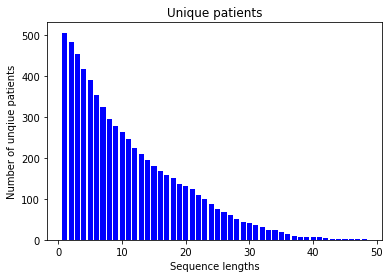

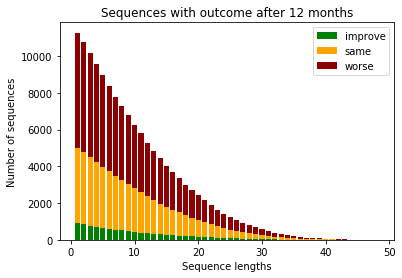

In [38]:
fig, ax = plt.subplots(1,1)
# subtract 2 from seq len because sequences contain 2 checkups
ax.bar(x=data['seq_len']-2, height=data['num_pat'], color='blue')
ax.set_ylabel('Number of unqiue patients')
ax.set_xlabel('Sequence lengths')
ax.set_title('Unique patients')

fig, ax = plt.subplots(1,1)
ax.bar(x=data['seq_len']-2, height=data['num_seq_impr'], color='green', label='improve')
ax.bar(x=data['seq_len']-2, height=data['num_seq_impr']+data['num_seq_same'], bottom=data['num_seq_impr'], color='orange', label='same')
ax.bar(x=data['seq_len']-2, height=data['num_seq'], bottom=data['num_seq_impr']+data['num_seq_same'], color='darkred', label='worse')
ax.set_ylabel('Number of sequences')
ax.set_xlabel('Sequence lengths')
ax.set_title('Sequences with outcome after 12 months')
ax.legend()

In [39]:
def get_summary_stats(stats, mask=None, checkup_stats={}):
    if mask is None:
        mask = np.ones(len(stats['len'])).astype(bool)
    data = {
        'num ts': len(stats['len'][mask]),
        'len mean': np.mean(stats['len'][mask]), 'len std': np.std(stats['len'][mask]),
        'dt mean': np.mean(stats['dt'][mask]), 'dt std': np.std(stats['dt'][mask]),
        'num_inj mean': np.mean(stats['num_inj'][mask]), 'num_inj std': np.std(stats['num_inj'][mask]),
        'va_mean mean': np.mean(stats['va_mean'][mask]), 'va_std mean': np.mean(stats['va_std'][mask]),
        'ls': np.mean(stats['ls'][mask])
    }
    for name, checkup in checkup_stats.items():
        data[name+' dt mean'] = np.mean(checkup['dt'][mask]) 
        data[name+' dt std'] = np.std(checkup['dt'][mask])
        data[name+' num_inj mean'] = np.mean(checkup['num_inj'][mask])
        data[name+' num_inj std'] = np.std(checkup['num_inj'][mask])
        data[name+' diff_va mean'] = np.mean(np.abs(checkup['diff_va'][mask]))
        data[name+' diff_va std'] = np.std(np.abs(checkup['diff_va'][mask]))
        data[name+' ls'] = np.mean(checkup['ls'][mask])
        
    return data

In [40]:
df = {}
# all data
mask = np.ones(len(stats['len']))
df['all'] = pd.Series(get_summary_stats(stats, checkup_stats=checkup_stats))
# binned in no change, improvement, worsening
for name, checkup in checkup_stats.items():
    diff_va = checkup['diff_va']
    mask_nochange = np.where((diff_va >= -measurement_error) & (diff_va <= measurement_error))[0]
    mask_impr = np.where(diff_va < -measurement_error)[0]
    mask_worse = np.where(diff_va > measurement_error)[0]
    df['no change after {}'.format(name)] = pd.Series(get_summary_stats(stats, mask=mask_nochange, checkup_stats=checkup_stats))
    df['improvement after {}'.format(name)] = pd.Series(get_summary_stats(stats, mask=mask_impr, checkup_stats=checkup_stats))
    df['worse after {}'.format(name)] = pd.Series(get_summary_stats(stats, mask=mask_worse, checkup_stats=checkup_stats))


In [41]:
pd.DataFrame(df)

,all,no change after checkup3,improvement after checkup3,worse after checkup3,no change after checkup12,improvement after checkup12,worse after checkup12
num ts,6284.000000,4691.000000,791.000000,802.000000,4094.000000,903.000000,1287.000000
len mean,12.494908,12.961629,10.328698,11.901496,12.890327,11.246955,12.112665
len std,8.819543,8.868218,8.265547,8.708011,8.723704,8.701518,9.102057
dt mean,654.650064,676.077169,542.451327,639.980050,679.019541,585.238095,625.831391
dt std,440.673968,435.566771,442.009925,451.541314,436.387557,457.423048,435.313934
num_inj mean,2.768619,2.875506,2.198483,2.705736,2.827308,2.272425,2.930070
num_inj std,3.676347,3.720154,3.399234,3.628055,3.672037,3.466176,3.802599
va_mean mean,0.508025,0.465418,0.676714,0.590860,0.458832,0.656774,0.560141
va_std mean,0.113385,0.104528,0.142562,0.136413,0.105482,0.139611,0.120121
ls,0.446531,0.441910,0.472819,0.447631,0.452858,0.442968,0.428904


No clear relationsip between extreme changes after 3 months and after 12 months


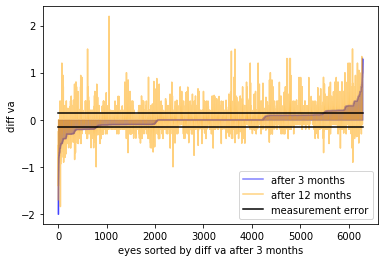

In [42]:
diff_va = checkup_stats['checkup3']['diff_va']
diff_va12 = checkup_stats['checkup12']['diff_va']
ids = np.argsort(diff_va)

plt.plot(range(len(diff_va)), diff_va[ids], alpha=0.5, label='after 3 months', color='blue')
plt.fill_between(range(len(diff_va)), 0, diff_va[ids], alpha=0.5, color='blue')
plt.plot(range(len(diff_va)), diff_va12[ids], alpha=0.5, color='orange', label='after 12 months')
plt.fill_between(range(len(diff_va)), 0, diff_va12[ids], facecolor='orange', alpha=0.5)
plt.plot([0,len(diff_va)], [measurement_error,measurement_error], color='black', label='measurement error')
plt.plot([0,len(diff_va)], [-measurement_error,-measurement_error], color='black')
plt.legend()

plt.ylabel('diff va')
plt.xlabel('eyes sorted by diff va after 3 months')
print("No clear relationsip between extreme changes after 3 months and after 12 months")

No clear relationsip between extreme changes after 3 months and after 12 months


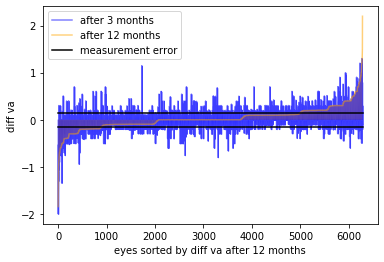

In [43]:
diff_va = checkup_stats['checkup3']['diff_va']
diff_va12 = checkup_stats['checkup12']['diff_va']
ids = np.argsort(diff_va12)

plt.plot(range(len(diff_va)), diff_va[ids], alpha=0.5, label='after 3 months', color='blue')
plt.fill_between(range(len(diff_va)), 0, diff_va[ids], alpha=0.5, color='blue')
plt.plot(range(len(diff_va)), diff_va12[ids], alpha=0.5, color='orange', label='after 12 months')
plt.fill_between(range(len(diff_va)), 0, diff_va12[ids], facecolor='orange', alpha=0.5)

plt.plot([0,len(diff_va)], [measurement_error,measurement_error], color='black', label='measurement error')
plt.plot([0,len(diff_va)], [-measurement_error,-measurement_error], color='black')
plt.legend()

plt.ylabel('diff va')
plt.xlabel('eyes sorted by diff va after 12 months')
print("No clear relationsip between extreme changes after 3 months and after 12 months")

In [44]:
def plot_hist2d(data, title=''):
    plt.figure()
    plt.imshow(data, cmap='Blues')
    plt.title('Difference in va after 3 months vs after 12 months '+title)
    plt.xlabel('diff in va after 3 months')
    plt.xticks([0,1,2],['improve','same','worse'])
    plt.ylabel('diff in va after 12 months')
    plt.yticks([0,1,2],['improve','same','worse'], rotation=90)
    for i,row in enumerate(data):
        for j,num in enumerate(row):
            plt.text(j,i,f'{num:.02f}',horizontalalignment='center',verticalalignment='center')
    plt.gca().invert_xaxis()
    _ = plt.colorbar()

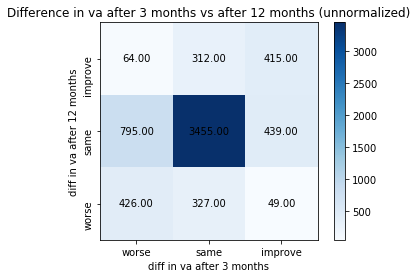

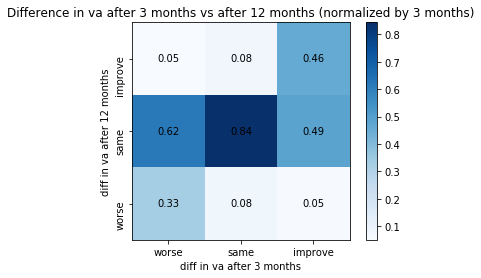

In [45]:
data, bins, _ = np.histogram2d(diff_va, diff_va12, bins=[-2,-measurement_error,measurement_error,2])
plot_hist2d(data, title='(unnormalized)')
plot_hist2d(data/data.sum(axis=0, keepdims=True), title='(normalized by 3 months)')

there is a difference between sequences that have injections vs that have no injections. But its not very big and I am not sure what it means


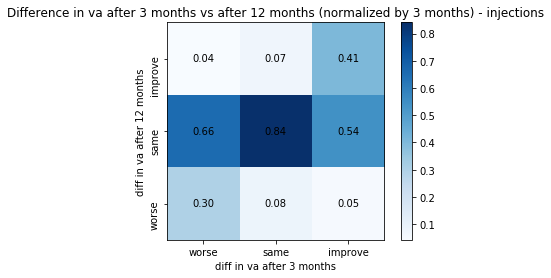

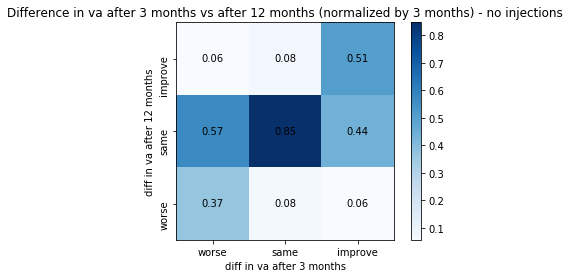

In [46]:
# plots statified by injections / no injections
inj = stats['num_inj'] + checkup_stats['checkup3']['num_inj']
diff_va = checkup_stats['checkup3']['diff_va']
diff_va12 = checkup_stats['checkup12']['diff_va']

data, bins, _ = np.histogram2d(diff_va[inj!=0], diff_va12[inj!=0], bins=[-2,-measurement_error,measurement_error,2])
plot_hist2d(data/data.sum(axis=0, keepdims=True), title='(normalized by 3 months) - injections')
data, bins, _ = np.histogram2d(diff_va[inj==0], diff_va12[inj==0], bins=[-2,-measurement_error,measurement_error,2])
plot_hist2d(data/data.sum(axis=0, keepdims=True), title='(normalized by 3 months) - no injections')
print('there is a difference between sequences that have injections vs that have no injections. But its not very big and I am not sure what it means')


# Identify per-patient dataset with AMD patients with 3 injections
- try to identify dataset that Karsten et al used in their publication
(could be filtered by diagnosis, VA delta, has_checkup_3m, has_checkup_12m etc)


NOTE: Karsten et al had 738 AMD patients with 3 injections. We have only 387 because we use only patients with confirmed diagnoses and require an OCT at the start of the injections! (loose 3 because no OCT at start of sequence, 146 because have no OCT at all, and the rest (supposedly, did not check!) because have no confirmed AMD label for these patients - or maybe because we have a slightly different dataset!)

## **Conclusion**: these are too few data points to pursure this now, but could come back to this

In [534]:
seqs = []
i = 0
for name, group in tqdm(grouped_patients):
    # get events for this group
    group_events = None
    try:
        group_events = grouped_events.get_group(name)
    except KeyError as e:
        pass

    seq = sequences.MeasurementSequence.from_pandas(group)
    seq.add_events_from_pandas(group_events)
    seqs.append(seq)

# FOR TESTING PURPOSES
# compare results with new add_events_function
seqs2 = []
i = 0
for name, group in tqdm(grouped_patients):
    # get events for this group
    group_events = None
    try:
        group_events = grouped_events.get_group(name)
    except KeyError as e:
        pass

    seq = sequences.MeasurementSequence.from_pandas(group)
    seq.add_events_from_pandas_old(group_events)
    seqs2.append(seq)
    
print(np.all([seq2.to_dict() == seq.to_dict() for seq2, seq in zip(seqs2, seqs)]))

/Users/hannah.spitzer/opt/miniconda3/envs/lode/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


/Users/hannah.spitzer/opt/miniconda3/envs/lode/lib/python3.7/site-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



True


In [535]:
groups_with_injections = 0
for group in grouped_events:
    if ((group[1]['injection?']==True).sum()>=3):
        groups_with_injections += 1
print('all patients with confirmed diagnoses having at least 3 injections:', groups_with_injections)

seqs_with_injections = [seq for seq in seqs if seq.num_injections >= 3]
print('all patients with confirmed diagnoses and OCTs at beginning of measurement and at least 3 injections:', len(seqs_with_injections))

seqs_without_injections = [seq for seq in seqs if seq.num_injections == 0]
print('all patients with confirmed diagnoses and OCTs at beginning of measurement and no injections:', len(seqs_without_injections))


all patients with confirmed diagnoses having at least 3 injections: 536
all patients with confirmed diagnoses and OCTs at beginning of measurement and at least 3 injections: 387
all patients with confirmed diagnoses and OCTs at beginning of measurement and no injections: 792


In [335]:
def add_checkup_mmts(self, checkup_names=[], checkup_mmts=[]):
    """adds checkup_mmts to last mmt from sequence as attributes.
    Attribute names are determined by checkup_names"""
    # add mmts to self
    for name, mmt in zip(checkup_names, checkup_mmts):
        setattr(self.measurements[-1], name, mmt)
    